## Setup libraries

In [1]:
import os
import glob
import pytorch_lightning as pl
import torch.nn.functional as F
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import torch
import cv2
import torchvision
import random
import onnxruntime
import pycocotools
import onnxoptimizer


from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import ToPILImage
from torchvision.transforms import v2
from torchvision.transforms.v2 import functional as TF
from torchvision.models.detection import ssdlite
from torchvision.models.detection import ssd
from torchvision.models import mobilenetv3
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import LearningRateMonitor, EarlyStopping
from pytorch_lightning.loggers import CSVLogger
from PIL import Image, ImageDraw, ImageFont
from torchvision import io, utils
from torchvision.tv_tensors import BoundingBoxes, Mask
from torchvision import tv_tensors
from torchmetrics.detection import MeanAveragePrecision



# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# os.environ['TORCH_USE_CUDA_DSA'] = "1"
# torch.set_float32_matmul_precision('medium')

## Definition paths

In [2]:
root_dir = "Tensorflow/workspace/datasets"
images_dir = os.path.join(root_dir, "images")
annotations_dir = os.path.join(root_dir, "annotations")
xml_dir = os.path.join(root_dir, "xml_dir")
model_dir = os.path.join(root_dir, "model_dir")
log_dir = os.path.join(root_dir, "log")

print(log_dir)

Tensorflow/workspace/datasets/log


## Label images

In [ ]:
!labelImg

## Labelmap function

In [3]:
def label(name):
    # create list of label dictionaries

    # labels = [{'name':'Cap', 'id':1}, {'name':'noCap', 'id':2}]
    labels = [{'name':'__background__', 'id':0,'name':'pear', 'id':1,'name':'apple', 'id':2}]

    res = next((item for item in labels if item["name"] == name), False)
    return res['id']

# print('id= ',label('apple'))

category = pd.DataFrame({'name': ['__background__','pear', 'apple','bicycle','person','aeroplane','bird','bottle','car','motorbike','bus','boat','dog'],
                          'id': [0,1,2,3,4,5,6,7,8,9,10,11,12]})


def lab2id(nam):
    for index, row in category.iterrows():
        if row['name'] == nam:
            res = category.at[index,'id']
    return res

def id2lab(id):
    for index, row in category.iterrows():
        if row['id'] == id:
            res = category.at[index,'name']
    return res
print(lab2id('apple'))
print(id2lab(1))
category.head(15)

2
pear


,name,id
0,__background__,0
1,pear,1
2,apple,2
3,bicycle,3
4,person,4
5,aeroplane,5
6,bird,6
7,bottle,7
8,car,8
9,motorbike,9


## Convert xml to pd dataframe

In [4]:
def xml_to_pd(path):
    """Iterates through all .xml files (generated by labelImg) in a given directory and combines
    them in a single Pandas dataframe.

    Parameters:
    ----------
    path : str
        The path containing the .xml files
    Returns
    -------
    Pandas DataFrame
        The produced dataframe
    """
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        filename = root.find('filename').text
        width = int(root.find('size').find('width').text)
        height = int(root.find('size').find('height').text)
        for member in root.findall('object'):
            bndbox = member.find('bndbox')
            value = (filename,
                    width,
                    height,
                    member.find('name').text,
                    int(bndbox.find('xmin').text),
                    int(bndbox.find('ymin').text),
                    int(bndbox.find('xmax').text),
                    int(bndbox.find('ymax').text),
                    )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height',
                'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df



df = xml_to_pd(xml_dir+'/xml_files')
# Writing dataframe to csv
# df.to_csv('./Tensorflow/workspace/datasets/annotation.csv')
# print('csv-file written')
num_classes = df['class'].nunique()+1 # include background
print('num_classes: ',num_classes)
df.head(15)

num_classes:  3


,filename,width,height,class,xmin,ymin,xmax,ymax
0,pear7.jpg,640,427,pear,217,78,457,375
1,apple14.jpg,640,427,apple,301,145,551,380
2,apple2.jpg,640,427,apple,221,100,410,290
3,apple2.jpg,640,427,apple,146,221,331,403
4,apple3.jpg,640,427,apple,240,171,392,328
5,apple4.jpg,640,331,apple,391,103,511,242
6,apple4.jpg,640,331,apple,515,136,598,241
7,pear3.jpg,640,427,pear,294,149,453,375
8,pear3.jpg,640,427,pear,395,141,551,297
9,pear3.jpg,640,427,pear,159,102,311,275


## Process panda dataframe

In [5]:
tel = 0
arr_old = None
arr_cl_old = None
filename_old = None
dfr = pd.DataFrame()
sample = {}
list_keys = []
list_val = []
list_class = []
stack_flag = False
#
for index, row in df.iterrows():

    filename = row['filename']
    # arr = np.array([row['ymin']/row['height'],row['xmin']/row['width'],row['ymax']/row['height'],row['xmax']/row['width']])
    arr = np.array([row['xmin'],row['ymin'],row['xmax'],row['ymax']])
    # cl = [label(row['class'])]
    cl = [lab2id(row['class'])]
    stack_flag = False
    if (index != tel) and (filename == filename_old) :
        arr_st = np.vstack((arr,arr_old))
        cl_st = cl+cl_old
        stack_flag = True

    if (filename != filename_old):
        arr_st = np.reshape(arr, (-1, 4))
        cl_st = cl
        if filename_old != None:
            list_keys.append(filename_old)
            list_val.append(arr_old)
            list_class.append(cl_old)

    if index == df.shape[0]-1 and not stack_flag:
        list_keys.append(filename)
        list_val.append(arr_st)
        list_class.append(cl_st)

    tel = index
    arr_old = arr_st
    cl_old =cl_st
    filename_old =filename

sample = {'image':list_keys,'bbox':list_val,'label':list_class}
# print(sample)
dframe = pd.DataFrame(sample)
dfr = dframe.sample(frac=1)
dfr.reset_index(inplace=True, drop=True)

# split dataset in train_ds en val_ds
# indices_or_sections = [int(0.8 * len(dfr))]
# train_ds, val_ds = np.split(dfr, indices_or_sections)

print('size dataset: ',len(dfr))
dfr.head(30)
# print(dfr)

size dataset:  27


,image,bbox,label
0,pear5.jpg,"[[281, 89, 574, 406]]",[1]
1,pear4.jpg,"[[158, 60, 514, 356]]",[1]
2,apple13.jpg,"[[145, 64, 245, 156], [215, 208, 341, 328]]","[2, 2]"
3,pear1.jpg,"[[417, 49, 504, 183], [295, 149, 385, 283], [2...","[1, 1, 1]"
4,pear12.jpg,"[[235, 68, 419, 367]]",[1]
5,pear9.jpg,"[[248, 159, 473, 414]]",[1]
6,apple9.jpg,"[[205, 147, 316, 257], [372, 144, 490, 264], [...","[2, 2, 2]"
7,apple4.jpg,"[[515, 136, 598, 241], [391, 103, 511, 242]]","[2, 2]"
8,apple7.jpg,"[[44, 224, 198, 360]]",[2]
9,pear6.jpg,"[[336, 31, 587, 282], [204, 164, 424, 413]]","[1, 1]"


## Convert panda dataframe to pytorch dataframe

In [6]:
# random.seed(12)

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data
        self.transforms = v2.Compose([
            v2.Resize(size=(320,320)),
            # v2.RandomHorizontalFlip(p=0.5),    
            ])
        self.idx_1 = -1
    
    def __getitem__(self, idx):

        # record
        record = self.data.iloc[idx]

        # load images
        to_tensor = torchvision.transforms.ToTensor()
        img_path = images_dir + '/' + record['image']
        img = Image.open(img_path)
        img = to_tensor(img)
        

        # get bounding box coordinates and labels for each record
        boxes = record['bbox']
        labels = torch.as_tensor((record['label']), dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[..., 3] - boxes[..., 1]) * (boxes[..., 2] - boxes[..., 0]) # three dots slice: as many as needed

        target = {}
        target["boxes"] = BoundingBoxes(boxes,format='xyxy',canvas_size=img.shape[-2:],dtype=torch.float32)
        target["labels"] = labels
        target["image_id"] = image_id
        # target["area"] = area
        
        _, width = img.shape[-2:]
        bbox = target["boxes"]
        if idx != self.idx_1:
            self.flag = random.random() > 0.5

        # random horizontal flip image + boudingbox        
        if self.flag:
            img = img.flip(-1)
            bbox[..., [0, 2]] = width - bbox[..., [2, 0]]
            target["boxes"] = bbox

        if self.transforms is not None:
            img, target = self.transforms(img, target)
            
        self.idx_1 = idx # if new idx apply random horizontal flip   
        return img, target # output tuple (img,target)
        
    
    def __len__(self):
        return len(self.data)
    
 


## DataLoader

labels: torch.Size([3]) tensor([1, 1, 1])


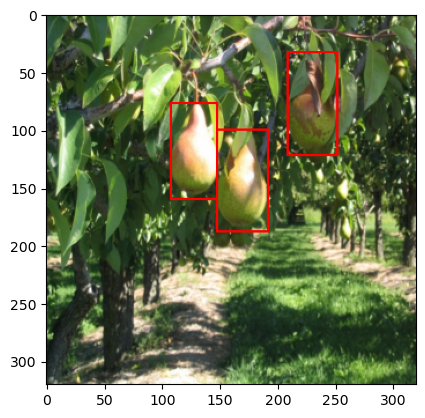

In [7]:
def collate_fn(batch):
    """
    To handle the data loading as different images may have different number 
    of objects and to handle varying size tensors as well.
    """
    return tuple(zip(*batch))

train_set_full = CustomDataset(dfr)
# train_set_size = int(len(train_set_full) * 0.95)
# valid_set_size = len(train_set_full) - train_set_size
# train, validate = random_split(train_set_full, [train_set_size, valid_set_size])
# print(len(train),len(validate))
# trdat = DataLoader(train,batch_size=2,shuffle=True,drop_last=True,collate_fn=collate_fn,num_workers=0) # set to 0 for debugging
# valdat = DataLoader(validate,batch_size=2,shuffle=False,drop_last=True,collate_fn=collate_fn,num_workers=0)

targets = train_set_full[3][1]
images = train_set_full[3][0]
tar = [{k: v} for k, v in targets.items() ] 
bboxes = tar[0]['boxes']
label = tar[1]['labels']
print('labels:',label.shape,label)
# print('bboxes:',bboxes)
# print(bboxes[0])
imag = images.numpy()
imag = np.uint8(imag*255)
imag = torch.from_numpy(imag)
viz = utils.draw_bounding_boxes(imag, boxes=bboxes,width=2,colors=(255,0,0))
viz = np.transpose(viz, (1,2,0))
plt.imshow(viz)

## Lightning module

In [8]:
from typing import Any


class CustomSSD(pl.LightningModule):
    def __init__(self,num_classes):
        super().__init__()
        self.num_classes = num_classes #background + 2 objects (background=0, pear=1, apple=2)
        self.cust_model =ssdlite.ssdlite320_mobilenet_v3_large(weights_backbone=ssdlite.MobileNet_V3_Large_Weights.IMAGENET1K_V1,
                    num_classes=self.num_classes,score_thresh=0.2)

    def prepare_data(self):
        self.train_set_full = CustomDataset(dfr)

    def setup(self, stage: str):
        # Assign train/val datasets for use in dataloaders
        if stage == "fit":
            train_set_size = int(len(train_set_full) * 0.95)
            valid_set_size = len(train_set_full) - train_set_size
            self.trdat, self.valdat = random_split(train_set_full, [train_set_size, valid_set_size])

    def train_dataloader(self):
        return DataLoader(self.trdat,batch_size=2,shuffle=True,drop_last=True,collate_fn=collate_fn,num_workers=6)# set to 0 for debugging

    def val_dataloader(self):
        return DataLoader(self.valdat,batch_size=1,shuffle=False,drop_last=True,collate_fn=collate_fn,num_workers=6)# set to 0 for debugging      

    def forward(self,xb):
        output = self.cust_model(xb)
        return output
        
    def training_step(self,batch,batch_idx,*args,**kwargs):
        images,targets = batch
        targets = [{k: v for k, v in t.items()} for t in targets]  # Unpack the Targets
        loss_dict = self.cust_model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        loss = torch.as_tensor(loss)
        logs = {"train_loss": loss}        
        return {"loss": loss, "log": loss_dict, "progress_bar": loss_dict}
    

    def validation_step(self, batch,batch_idx,*args,**kwargs):
        images,targets = batch  # unpack the one batch from the DataLoader
        # targets = [{k: v for k, v in targets[0].items()}]  # Unpack the Targets if batch=1
        targets = [{k: v for k, v in t.items()} for t in targets]  # Unpack the Targets
        outputs = self.cust_model(images, targets)
        target = []
        preds = []        
        for i in range(len(images)):
            true_dict = dict()
            preds_dict = dict()
            true_dict['boxes'] = targets[i]['boxes'].detach()
            true_dict['labels'] = targets[i]['labels'].detach()
            preds_dict['boxes'] = outputs[i]['boxes'].detach()
            preds_dict['scores'] = outputs[i]['scores'].detach()
            preds_dict['labels'] = outputs[i]['labels'].detach()
            preds.append(preds_dict)
            target.append(true_dict)
        metric = MeanAveragePrecision()
        metric.update(preds, target)
        metric_summary = metric.compute()
        self.log("val_acc", metric_summary['map'], on_step=False, on_epoch=True, prog_bar=True)
        logs = {"val_acc": metric_summary['map']}
        return {"val_acc": metric_summary['map'],"log": logs,"progress_bar": logs,}
        
    
    def configure_optimizers(self, *args, **kwargs):
        # params = [p for p in self.cust_model.parameters() if p.requires_grad]
        params = self.cust_model.parameters()
        self.optimizer = torch.optim.SGD(params,lr=0.0025,momentum=0.9)
        self.lr_scheduler = torch.optim.lr_scheduler.ConstantLR(optimizer=self.optimizer,factor=0.5,total_iters=50)
        return [self.optimizer],[self.lr_scheduler]

        
    

## Lightning trainer

In [51]:
# 1 epoch = number images/ images/step(batch size) -> 1 epoch = 40(train images)/2(batch size) =20 steps
logger = CSVLogger(log_dir, name="cust_retina")
lr_logger  = LearningRateMonitor(logging_interval="step")

#instantiate LightningTrainer
trainer    = Trainer(precision='32', callbacks=[lr_logger], max_epochs=300, logger=logger, log_every_n_steps=1)
CustomModel = CustomSSD(num_classes=num_classes)
# trainer.fit(CustomModel,trdat,valdat)
trainer.fit(CustomModel)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type | Params
------------------------------------
0 | cust_model | SSD  | 3.7 M 
------------------------------------
3.7 M     Trainable params
0         Non-trainable params
3.7 M     Total params
14.902    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

## Save model & create inference model

In [40]:
torch.save(CustomModel.cust_model.state_dict(), model_dir+"/torch/trained_weights.pth")
trainer.save_checkpoint(filepath=model_dir+"/torch/final.ckpt")

### inference pytorch

In [ ]:
model = ssdlite.ssdlite320_mobilenet_v3_large(num_classes=num_classes)
state_dict = torch.load(model_dir+"/torch/trained_weights.pth")
model.load_state_dict(state_dict=state_dict)
model.eval()

### inference pylightning

In [11]:
model_ckpt = CustomSSD.load_from_checkpoint(model_dir+"/torch/final.ckpt",num_classes=num_classes)
model_ckpt.eval()

CustomSSD(
  (cust_model): SSD(
    (backbone): SSDLiteFeatureExtractorMobileNet(
      (features): Sequential(
        (0): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
            (2): Hardswish()
          )
          (1): InvertedResidual(
            (block): Sequential(
              (0): Conv2dNormActivation(
                (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
                (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
                (2): ReLU(inplace=True)
              )
              (1): Conv2dNormActivation(
                (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stat

## Inference on testset

type predictions; <class 'list'> 1
[{'boxes': tensor([[279.7170, 183.9204, 449.1612, 333.4102],
        [116.1593, 143.5522, 287.8622, 321.5471],
        [125.2562,  45.1019, 260.5755, 175.9524]], grad_fn=<StackBackward0>), 'scores': tensor([1.0000, 1.0000, 0.9999], grad_fn=<IndexBackward0>), 'labels': tensor([2, 2, 2])}]
boxes: tensor([[279.7170, 183.9204, 449.1612, 333.4102],
        [116.1593, 143.5522, 287.8622, 321.5471],
        [125.2562,  45.1019, 260.5755, 175.9524]], grad_fn=<IndexBackward0>)
scores: tensor([1.0000, 1.0000, 0.9999], grad_fn=<IndexBackward0>)
labels: tensor([2, 2, 2])
['apple: 100%', 'apple: 100%', 'apple: 100%']


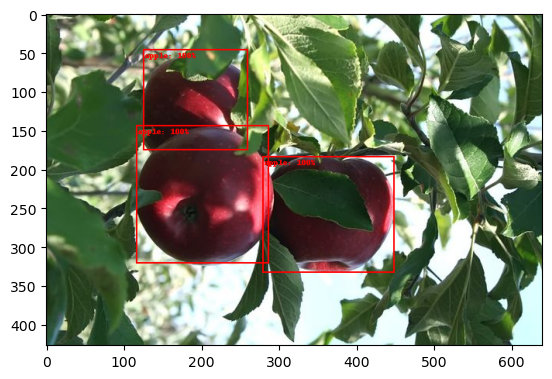

In [12]:
imag_file = random.choice(os.listdir(images_dir))
to_tensor = torchvision.transforms.ToTensor()
img = Image.open(images_dir+'/'+imag_file)
# img = Image.open(images_dir+'/'+ 'peer_appel.jpg')
images = to_tensor(img)
# print('images:',images,images.shape)
imag = images.numpy()
imag = np.uint8(imag*255)
imag = torch.from_numpy(imag)

predictions = model_ckpt([images]) #list of dicts
print('type predictions;',type(predictions),len(predictions))
targets = [{k: v for k, v in predictions[0].items()}]
print(targets)
scores = torch.as_tensor(predictions[0]['scores'])
labels = torch.as_tensor(predictions[0]['labels'])
boxes = torch.as_tensor(predictions[0]['boxes'])
threshold = 0.6
mask   = scores > threshold
boxes  = boxes[mask]
labels = labels[mask]
scores = scores[mask]

print('boxes:',boxes)
print('scores:',scores)
print('labels:',labels)
label_map = []
for i in range(len(labels.tolist())):
    lab = id2lab(labels.tolist()[i])
    scor = str(round(100*scores.tolist()[i]))
    lab = "{}: {}%".format(lab, scor)
    label_map.append(lab)
print(label_map)
viz = utils.draw_bounding_boxes(imag, boxes=boxes,labels=label_map,width=2,colors=(255,0,0))
viz = np.transpose(viz, (1,2,0))
plt.imshow(viz)


## Convert to onnx (1)
### view in https://netron.app/

In [13]:
model_onnx = model_ckpt
filepath = model_dir + "/" +"model.onnx"
input_sample = [torch.randn((3, 320,320))]
model_onnx.to_onnx(filepath, input_sample, export_params=True)


/home/avncalst/.local/lib/python3.10/site-packages/torchvision/ops/boxes.py:166: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes_x = torch.min(boxes_x, torch.tensor(width, dtype=boxes.dtype, device=boxes.device))
/home/avncalst/.local/lib/python3.10/site-packages/torchvision/ops/boxes.py:168: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes_y = torch.min(boxes_y, torch.tensor(height, dtype=boxes.dtype, device=boxes.device))
/home/avncalst/.local/lib/python3.10/site-packages/torchvision/models/detection/transform.py:308: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather 

## Convert to onnx (2)
### view in https://netron.app/

In [14]:
batch_size = 1
# Input to the model
# x = torch.randn(batch_size, 3, 320, 320, requires_grad=True)
# x = torch.randn(1, 3, 320, 320, requires_grad=True)
x = [torch.randn( 3, 320, 320, requires_grad=True)]
torch_out = model_onnx(x)

# Export the model
torch.onnx.export(model_onnx,                               # model being run
                  x,                                        # model input (or a tuple for multiple inputs)
                  model_dir + "/" +"mobilenet_v3.onnx",     # where to save the model (can be a file or file-like object)
                  export_params=True,                       # store the trained parameter weights inside the model file
                  opset_version=11,                         # the ONNX version to export the model to
                  do_constant_folding=True,                 # whether to execute constant folding for optimization
                  input_names = ['input'],                  # the model's input names
                  output_names = ['boxes','labels','scores'],                # the model's output names
                #   dynamic_axes={'input':{0: 'batch_size'},# variable length axes
                                # 'output':{0: 'batch_size'}}
                )


## Inference onnx (1),(2)

type predictions: <class 'list'>
boxes,shape: [[139.90349  137.55257  224.11876  248.99834 ]
 [ 58.011654 107.688354 143.56274  241.28522 ]
 [ 62.76582   33.433445 130.43861  131.61887 ]] (3, 4)
labels: [2 2 2]
scores: [0.9999995 0.9999995 0.9999635]
['apple: 100%', 'apple: 100%', 'apple: 100%']


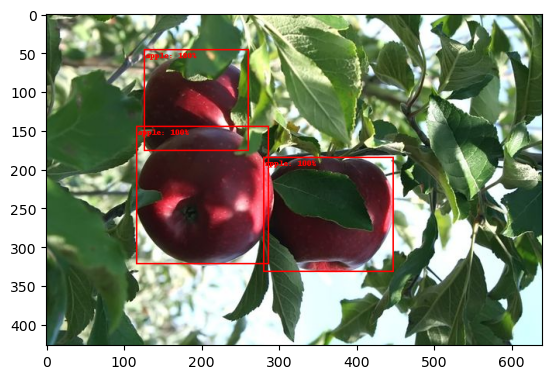

In [15]:
version = False # True: model.onnx; False: mobilenet_v3.onnx

resize = v2.Resize(size=(320,320))
imag_onnx = resize(img)

if version:
    imag_onnx = to_tensor(imag_onnx)
    filepath = model_dir + "/" +"model.onnx"
else:
    imag_onnx = to_tensor(imag_onnx)
    # imag_onnx = imag_onnx[None, ...]
    filepath = model_dir + "/" +"mobilenet_v3.onnx"

# print(imag_onnx, imag_onnx.shape)
ort_session = onnxruntime.InferenceSession(filepath)
ort_inputs = {ort_session.get_inputs()[0].name: imag_onnx.numpy()}
# ort_inputs = {input_name: imag_onnx}
predictions = ort_session.run(None, ort_inputs)
print('type predictions:',type(predictions))

# boxes = torch.from_numpy(predictions[0])
# scores = torch.from_numpy( predictions[1])
# labels = torch.from_numpy(predictions[2])

boxes = predictions[0]
scores = predictions[1]
labels = predictions[2]

threshold = 0.6
mask   = scores > threshold
boxes  = boxes[mask]
labels = labels[mask]
scores = scores[mask]
print('boxes,shape:', boxes,boxes.shape)
print('labels:',labels)
print('scores:',scores)

orig_height, orig_width = imag.shape[1], imag.shape[2]
width_scale = orig_width / 320
heigth_scale = orig_height / 320
# print(orig_height, orig_width)
# print(width_scale,heigth_scale)

label_map = []
for i in range(len(labels.tolist())):
    lab = id2lab(labels.tolist()[i])
    scor = str(round(100*scores.tolist()[i]))
    lab = "{}: {}%".format(lab, scor)
    label_map.append(lab)
    boxes[i][0] = round((boxes[i][0] * width_scale).item()) 
    boxes[i][1] = round((boxes[i][1] * heigth_scale).item()) 
    boxes[i][2] = round((boxes[i][2] * width_scale).item()) 
    boxes[i][3] = round((boxes[i][3] * heigth_scale).item())   

print(label_map)
# print(boxes)
boxes = torch.from_numpy(boxes)
viz = utils.draw_bounding_boxes(imag, boxes=boxes,labels=label_map,width=2,colors=(255,0,0))
viz = np.transpose(viz, (1,2,0))
plt.imshow(viz)

